## Google Trends Augmented Models

Questa è la prima versione della stima del Modello Aumentato *in-sample*. Generalmente corretto, tuttavia manchevole di talune analisi (correlazione tra gli indici GT) fondamentali per indagare meglio i risultati ottenuti, un po' inaspettati: entrambi gli indici GT **non sono statisticamente significativi**.

>>> INIZIO SCRIPT: Modelli SARIMAX Aumentati con Indici Google Trends <<<

I risultati di questo script verranno salvati in: '/Users/tommaso/Desktop/tesi-inflation-gt/SARIMAX_modelli/modelli_aumentati_gt_v1'

--- Caricamento Serie Stazionarie da: /Users/tommaso/Desktop/tesi-inflation-gt/First_Difference_indexes/dati_preparati_fase2/indici_gt_nic_stazionari_fase2.csv ---
Serie caricate. Shape: (252, 3)
Serie inflazione 'NIC_destag_ISTAT_diff1' pronta: 251 osservazioni.

--- Preparazione Dummies Outlier di Base ---
Creata dummy: d_outlier_2022_01_1m (attiva per 1 periodi)
Creata dummy: d_outlier_2022_10_1m (attiva per 1 periodi)
Dummies outlier di base create e allineate.

--- Stima Modello Base di Riferimento (solo con Dummies Outlier) ---
  Tentativo HAC fallito per Modello Base: Invalid covariance matrix type....
  Modello Base: AIC=64.865, BIC=82.492, CovType=Robust
                                 SARIMAX Results                                  
Dep. Variable:     NIC_destag_ISTAT_

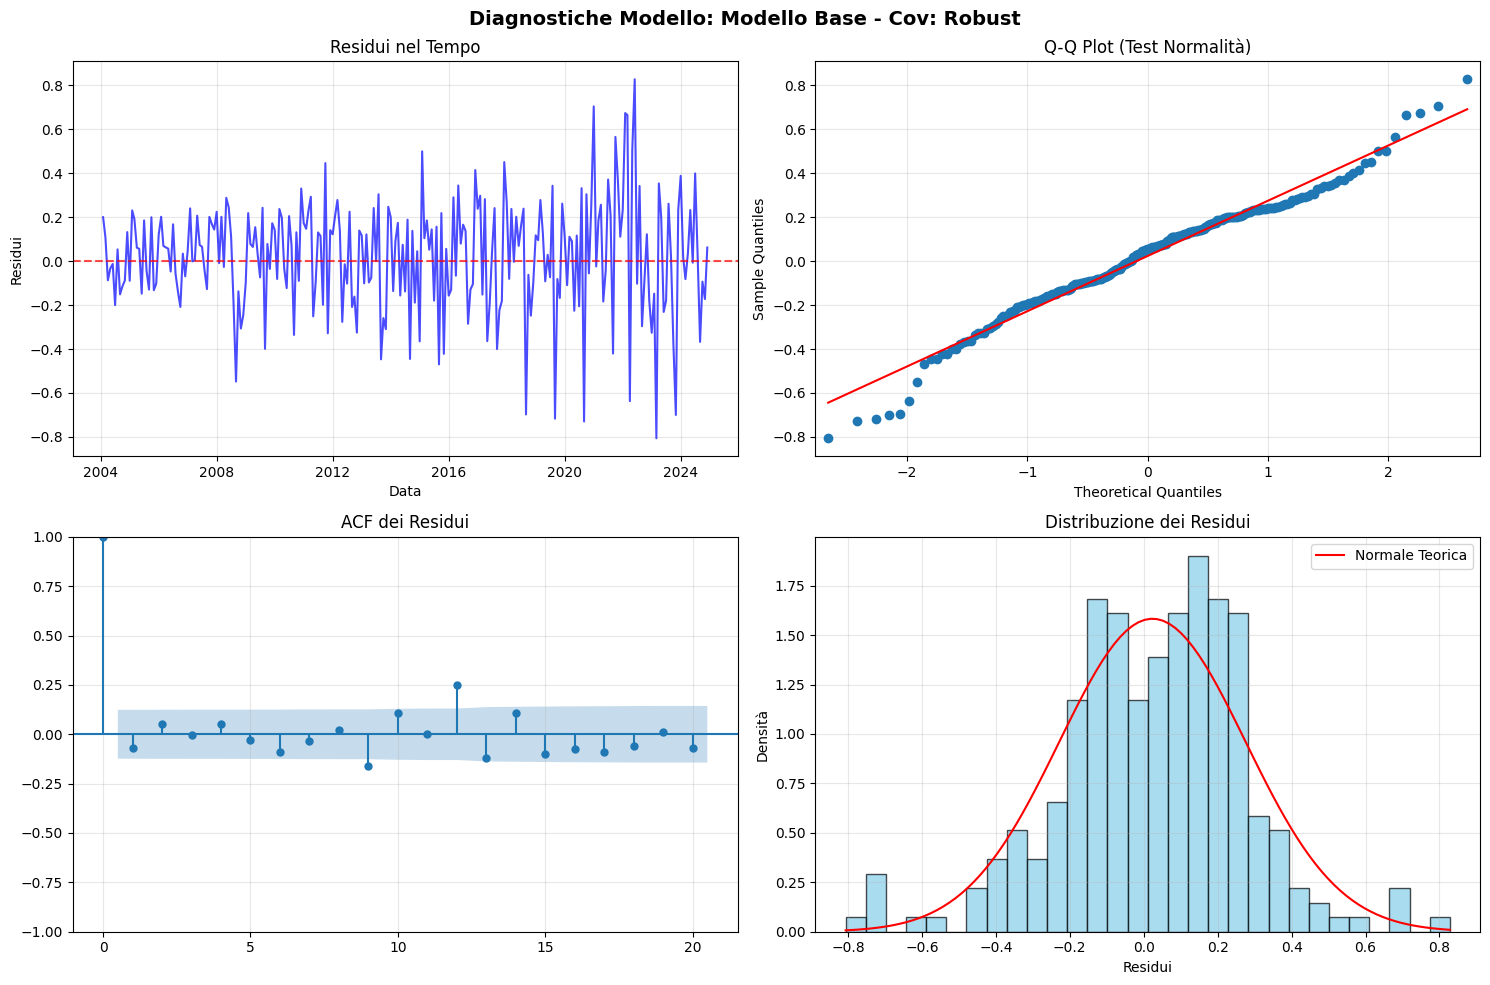


--- Test Statistici sui Residui (Modello Base - Cov: Robust) ---
Test Ljung-Box (H0: no autocorr.): p-value min = 0.1439
  -> OK: Nessuna evidenza di autocorrelazione residua
Test Jarque-Bera (H0: normalità): statistica = 15.731, p-value = 0.0004
  -> ATTENZIONE: Residui potrebbero non essere normali (p < 0.05)

--- Ricerca Lag Ottimale per: indice_Inflazione_GT_PCA_SA_diff1 (max_lag=12) ---
  Tentativo HAC fallito per Base + indice_Inflazione_GT_PCA_SA_diff1_lag1: Invalid covariance matrix type....
  Base + indice_Inflazione_GT_PCA_SA_diff1_lag1: AIC=67.050, BIC=88.178, CovType=Robust
  Tentativo HAC fallito per Base + indice_Inflazione_GT_PCA_SA_diff1_lag2: Invalid covariance matrix type....
  Base + indice_Inflazione_GT_PCA_SA_diff1_lag2: AIC=67.300, BIC=88.404, CovType=Robust
  Tentativo HAC fallito per Base + indice_Inflazione_GT_PCA_SA_diff1_lag3: Invalid covariance matrix type....
  Base + indice_Inflazione_GT_PCA_SA_diff1_lag3: AIC=65.967, BIC=87.048, CovType=Robust
  Tentativ

/var/folders/3m/15k2tqw90_s76rn9_8yw2p3r0000gn/T/ipykernel_46352/2605421056.py:345: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  print(df_lag_selection_results.groupby('GT_Index').apply(lambda x: x.loc[x['Criterio_Val'].idxmin()]))


Diagnostiche salvate in: /Users/tommaso/Desktop/tesi-inflation-gt/SARIMAX_modelli/modelli_aumentati_gt_v1/diagnostica_modello_finale_augmentato.png


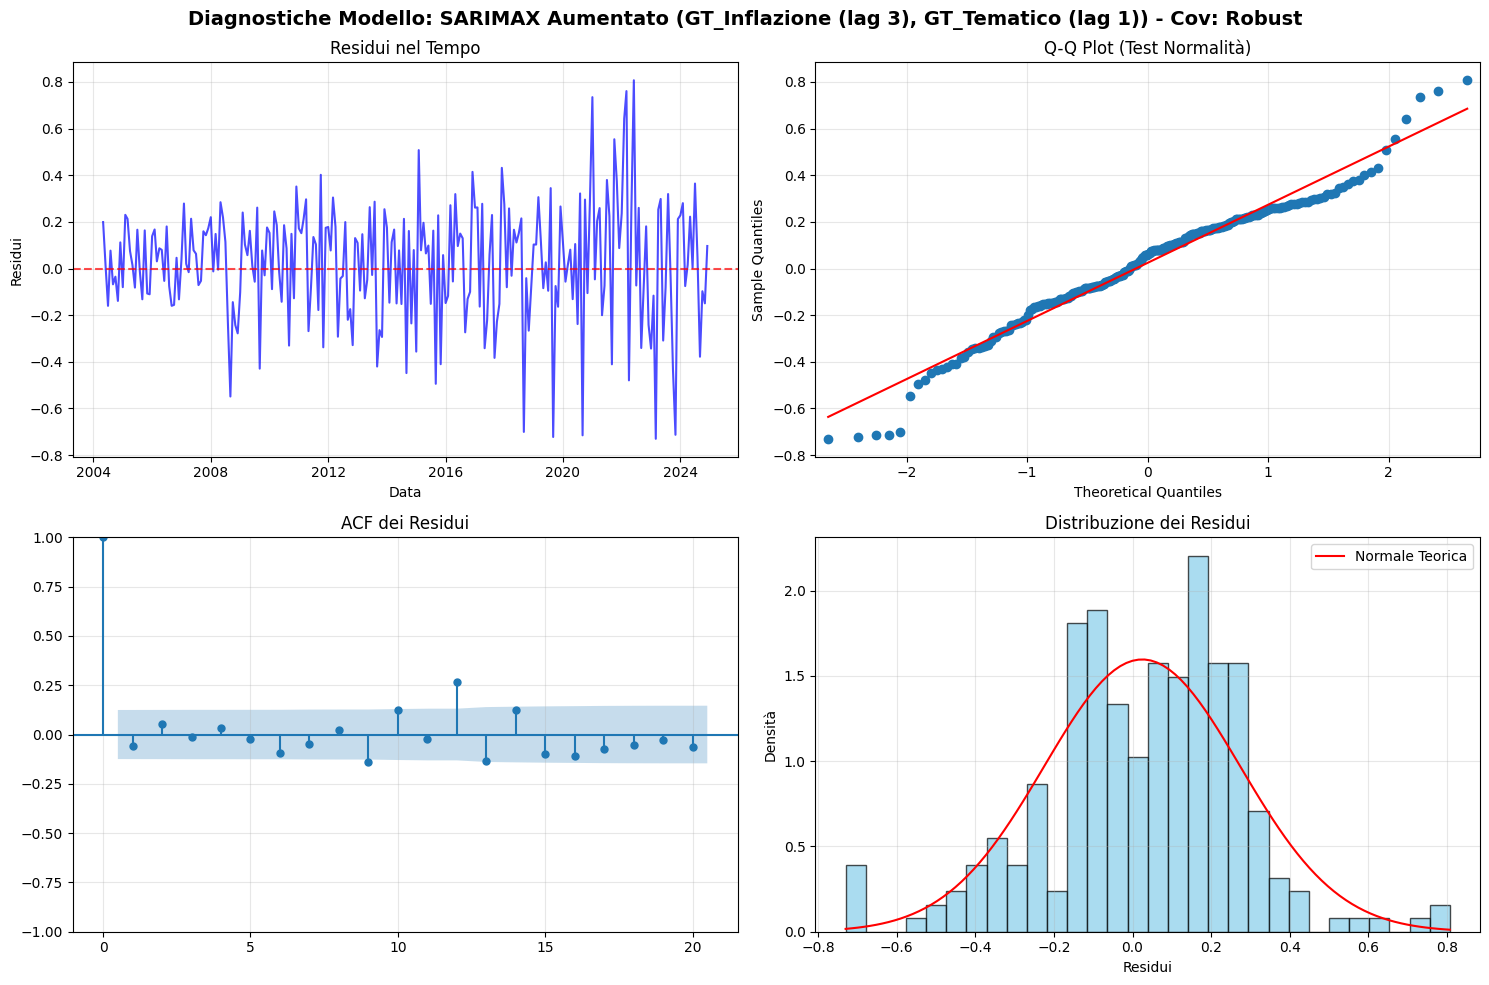


--- Test Statistici sui Residui (SARIMAX Aumentato (GT_Inflazione (lag 3), GT_Tematico (lag 1)) - Cov: Robust) ---
Test Ljung-Box (H0: no autocorr.): p-value min = 0.1711
  -> OK: Nessuna evidenza di autocorrelazione residua
Test Jarque-Bera (H0: normalità): statistica = 14.239, p-value = 0.0008
  -> ATTENZIONE: Residui potrebbero non essere normali (p < 0.05)
Plot del fit in-sample salvato in: /Users/tommaso/Desktop/tesi-inflation-gt/SARIMAX_modelli/modelli_aumentati_gt_v1/fit_insample_modello_augmentato.png


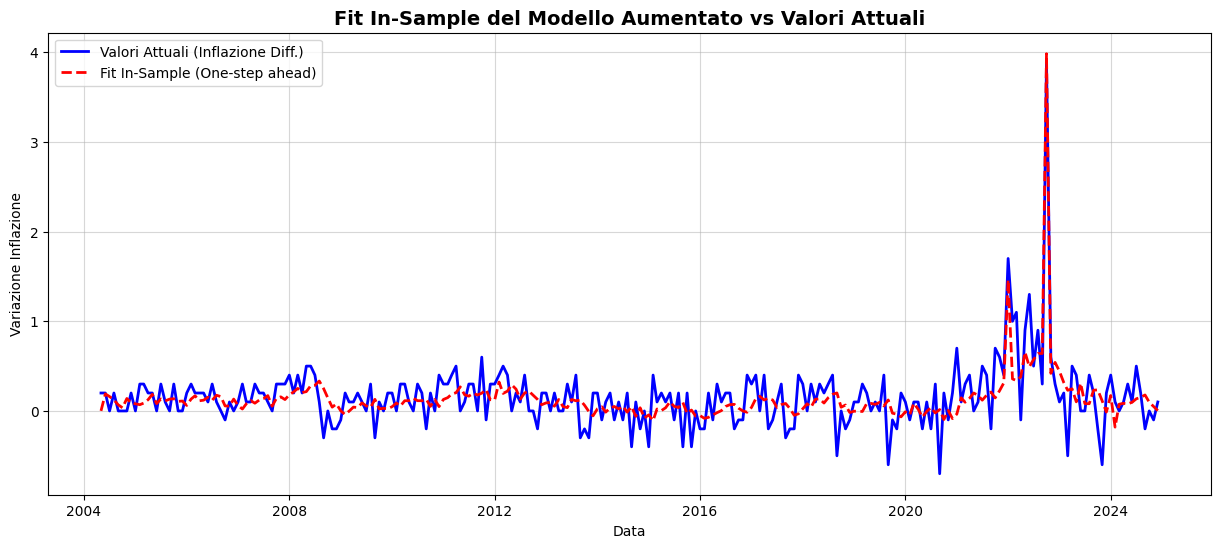


--- Confronto Modelli (Criterio: AIC) ---
                   Modello    AIC    BIC  Criterio  N_Params
  Base + Tematico_GT(lag1) 64.253 85.381    64.253         6
  Modello Finale Aumentato 64.498 89.092    64.498         7
              Modello Base 64.865 82.492    64.865         5
Base + Inflazione_GT(lag3) 65.967 87.048    65.967         6

MIGLIOR MODELLO: Base + Tematico_GT(lag1) (AIC: 64.253)
Confronto modelli salvato in: /Users/tommaso/Desktop/tesi-inflation-gt/SARIMAX_modelli/modelli_aumentati_gt_v1/confronto_modelli_aic.csv

>>> SCRIPT MODELLI AUMENTATI COMPLETATO <<<


In [ ]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import itertools
import warnings
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from scipy.stats import jarque_bera
import pickle

# Ignoro i warning per un output più pulito
warnings.filterwarnings("ignore", category=sm.tools.sm_exceptions.ConvergenceWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

# --- CONFIGURAZIONE GENERALE ---
PATH_INPUT_DIR_FASE2 = "/Users/tommaso/Desktop/tesi-inflation-gt/First_Difference_indexes/dati_preparati_fase2"
FILE_SERIE_STAZIONARIE_IN = os.path.join(PATH_INPUT_DIR_FASE2, "indici_gt_nic_stazionari_fase2.csv")

PATH_OUTPUT_MODELLI_AUG = "/Users/tommaso/Desktop/tesi-inflation-gt/SARIMAX_modelli/modelli_aumentati_gt_v1"

COL_INFLAZIONE_STAZ = 'NIC_destag_ISTAT_diff1'
# Nomi delle colonne GT stazionarie (come da output Fase 2)
COL_GT_INFLAZIONE_STAZ = 'indice_Inflazione_GT_PCA_SA_diff1'
COL_GT_TEMATICO_STAZ = 'indice_Tematico_GT_SA_diff1'

# Dummies per outlier (definite come nello script precedente del modello base)
DUMMY_GEN2022_DATE = '2022-01-01'
DUMMY_OTT2022_DATE = '2022-10-01'
# Non includiamo la dummy guerra qui, ci concentriamo sull'aggiunta dei GT al modello base con outlier dummies

# Ordini del modello SARIMAX base (identificati precedentemente)
BASE_ORDER = (1, 0, 1)
BASE_SEASONAL_ORDER = (0, 0, 0, 12)

# Parametri per la ricerca dei lag ottimali per i GT
MAX_GT_LAG_TO_TEST = 12 # Testo fino a 12 lag per ciascun indice GT
CRITERION_SELEZIONE_LAG = 'aic' # 'aic' o 'bic'

# --- FUNZIONI AUSILIARIE (Caricamento, Creazione Dummy) ---
def carica_dati_stazionari(path_file):
    """Carica le serie stazionarie da file CSV."""
    print(f"--- Caricamento Serie Stazionarie da: {path_file} ---")
    try:
        df = pd.read_csv(path_file, index_col=0)
        df.index = pd.to_datetime(df.index)
        print(f"Serie caricate. Shape: {df.shape}")
        return df
    except Exception as e:
        print(f"ERRORE caricamento: {e}")
        return None

def crea_pulse_dummy(serie_index, event_date_str, duration_months=1, name_prefix="d_pulse"):
    """Crea una pulse dummy per un evento specifico con durata personalizzabile."""
    event_ts = pd.Timestamp(event_date_str)
    date_suffix = f"{event_ts.year}_{event_ts.month:02d}"
    dummy_name = f"{name_prefix}_{date_suffix}_{duration_months}m"
    dummy = pd.Series(0, index=serie_index, name=dummy_name)
    end_event = event_ts + pd.DateOffset(months=duration_months - 1)
    event_period = serie_index[(serie_index >= event_ts) & (serie_index <= end_event)]
    if not event_period.empty:
        dummy[event_period] = 1
    print(f"Creata dummy: {dummy_name} (attiva per {len(event_period)} periodi)")
    return dummy

def stima_e_valuta_sarimax(y_series, exog_series, order, seasonal_order, model_description="Modello"):
    """Funzione robusta per stimare un SARIMAX con gestione degli errori."""
    try:
        model = sm.tsa.SARIMAX(y_series, exog=exog_series, order=order, seasonal_order=seasonal_order,
                             enforce_stationarity=False, enforce_invertibility=False,
                             initialization='approximate_diffuse')
        
        # Sequenza di tentativi per la stima con diversi tipi di covarianza
        estimation_strategies = [
            ('HAC', {'cov_type': 'HAC', 'cov_kwds': {'kernel': 'bartlett', 'use_correction': True}}),
            ('Robust', {'cov_type': 'robust'}),
            ('Default', {})
        ]
        
        for strategy_name, fit_kwargs in estimation_strategies:
            try:
                fitted_model = model.fit(disp=False, maxiter=250, **fit_kwargs)
                aic = fitted_model.aic
                bic = fitted_model.bic
                print(f"  {model_description}: AIC={aic:.3f}, BIC={bic:.3f}, CovType={strategy_name}")
                return fitted_model, aic, bic, strategy_name
            except Exception as e:
                print(f"  Tentativo {strategy_name} fallito per {model_description}: {str(e)[:50]}...")
                continue
        
        # Se tutti i tentativi falliscono
        print(f"  ERRORE: Tutte le strategie di stima fallite per {model_description}")
        return None, float('inf'), float('inf'), "Fallita"
        
    except Exception as e:
        print(f"  ERRORE costruzione modello {model_description}: {str(e)[:50]}...")
        return None, float('inf'), float('inf'), "Fallita"

def plot_model_diagnostics(fitted_model, model_name="SARIMAX Model", path_output_grafici=None, save_filename="diagnostics.png"):
    """
    Crea un pannello di diagnostiche per il modello SARIMAX stimato.
    Questo include: residui, Q-Q plot, ACF dei residui, test statistici.
    """
    if fitted_model is None:
        print(f"Impossibile creare diagnostiche: modello {model_name} non valido.")
        return
    
    # Calcolo i residui
    residuals = fitted_model.resid
    
    # Creo una figura con 4 subplot
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle(f'Diagnostiche Modello: {model_name}', fontsize=14, fontweight='bold')
    
    # 1. Plot dei residui nel tempo
    axes[0, 0].plot(residuals.index, residuals, color='blue', alpha=0.7)
    axes[0, 0].axhline(y=0, color='red', linestyle='--', alpha=0.7)
    axes[0, 0].set_title('Residui nel Tempo')
    axes[0, 0].set_xlabel('Data')
    axes[0, 0].set_ylabel('Residui')
    axes[0, 0].grid(True, alpha=0.3)
    
    # 2. Q-Q Plot per normalità
    sm.qqplot(residuals, line='s', ax=axes[0, 1])
    axes[0, 1].set_title('Q-Q Plot (Test Normalità)')
    axes[0, 1].grid(True, alpha=0.3)
    
    # 3. ACF dei residui
    plot_acf(residuals, ax=axes[1, 0], lags=20, alpha=0.05)
    axes[1, 0].set_title('ACF dei Residui')
    axes[1, 0].grid(True, alpha=0.3)
    
    # 4. Istogramma dei residui
    axes[1, 1].hist(residuals, bins=30, density=True, alpha=0.7, color='skyblue', edgecolor='black')
    axes[1, 1].set_title('Distribuzione dei Residui')
    axes[1, 1].set_xlabel('Residui')
    axes[1, 1].set_ylabel('Densità')
    axes[1, 1].grid(True, alpha=0.3)
    
    # Aggiungo una curva normale di riferimento
    x_norm = np.linspace(residuals.min(), residuals.max(), 100)
    y_norm = (1/np.sqrt(2*np.pi*residuals.var())) * np.exp(-0.5*((x_norm - residuals.mean())/residuals.std())**2)
    axes[1, 1].plot(x_norm, y_norm, 'r-', label='Normale Teorica')
    axes[1, 1].legend()
    
    plt.tight_layout()
    
    # Salvo il plot se specificato
    if path_output_grafici and save_filename:
        save_path = os.path.join(path_output_grafici, save_filename)
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Diagnostiche salvate in: {save_path}")
    
    plt.show()
    
    # Test statistici sui residui
    print(f"\n--- Test Statistici sui Residui ({model_name}) ---")
    
    # Test di Ljung-Box per autocorrelazione
    try:
        ljung_box = acorr_ljungbox(residuals, lags=10, return_df=True)
        print(f"Test Ljung-Box (H0: no autocorr.): p-value min = {ljung_box['lb_pvalue'].min():.4f}")
        if ljung_box['lb_pvalue'].min() < 0.05:
            print("  -> ATTENZIONE: Possibile autocorrelazione residua (p < 0.05)")
        else:
            print("  -> OK: Nessuna evidenza di autocorrelazione residua")
    except Exception as e:
        print(f"  Errore test Ljung-Box: {e}")
    
    # Test di Jarque-Bera per normalità
    try:
        jb_stat, jb_pvalue = jarque_bera(residuals.dropna())
        print(f"Test Jarque-Bera (H0: normalità): statistica = {jb_stat:.3f}, p-value = {jb_pvalue:.4f}")
        if jb_pvalue < 0.05:
            print("  -> ATTENZIONE: Residui potrebbero non essere normali (p < 0.05)")
        else:
            print("  -> OK: Nessuna evidenza contro la normalità")
    except Exception as e:
        print(f"  Errore test Jarque-Bera: {e}")

def confronta_modelli(risultati_modelli, criterio='aic'):
    """
    Confronta i modelli stimati e identifica il migliore secondo il criterio specificato.
    
    Args:
        risultati_modelli: lista di tuple (nome_modello, aic, bic, fitted_model)
        criterio: 'aic' o 'bic'
    """
    print(f"\n--- Confronto Modelli (Criterio: {criterio.upper()}) ---")
    
    # Creo DataFrame per il confronto
    comparison_data = []
    for nome, aic, bic, model in risultati_modelli:
        if model is not None:
            comparison_data.append({
                'Modello': nome,
                'AIC': aic,
                'BIC': bic,
                'Criterio': aic if criterio == 'aic' else bic,
                'N_Params': len(model.params) if hasattr(model, 'params') else 'N/A'
            })
    
    if not comparison_data:
        print("Nessun modello valido da confrontare.")
        return None
    
    df_comparison = pd.DataFrame(comparison_data)
    df_comparison = df_comparison.sort_values('Criterio')
    
    print(df_comparison.to_string(index=False, float_format='%.3f'))
    
    # Identifica il migliore
    best_model = df_comparison.iloc[0]
    print(f"\nMIGLIOR MODELLO: {best_model['Modello']} ({criterio.upper()}: {best_model['Criterio']:.3f})")
    
    return df_comparison

# --- ESECUZIONE SCRIPT: MODELLI AUMENTATI CON GT ---
if __name__ == "__main__":
    print(">>> INIZIO SCRIPT: Modelli SARIMAX Aumentati con Indici Google Trends <<<\n")
    os.makedirs(PATH_OUTPUT_MODELLI_AUG, exist_ok=True)
    print(f"I risultati di questo script verranno salvati in: '{PATH_OUTPUT_MODELLI_AUG}'\n")

    # 1. Carico le mie serie stazionarie (output Fase 2)
    df_serie_stazionarie = carica_dati_stazionari(FILE_SERIE_STAZIONARIE_IN)
    if df_serie_stazionarie is None:
        print("ERRORE CRITICO: Dati non caricati.")
        exit()

    # Preparo la variabile dipendente (inflazione)
    if COL_INFLAZIONE_STAZ not in df_serie_stazionarie.columns:
        print(f"ERRORE: Colonna inflazione '{COL_INFLAZIONE_STAZ}' non trovata.")
        exit()
    
    y_inflazione = df_serie_stazionarie[COL_INFLAZIONE_STAZ].dropna()
    if y_inflazione.empty:
        print(f"ERRORE: Serie inflazione '{COL_INFLAZIONE_STAZ}' vuota.")
        exit()
    
    print(f"Serie inflazione '{y_inflazione.name}' pronta: {len(y_inflazione)} osservazioni.")

    # 2. Preparo le variabili esogene di base (le dummy outlier)
    print("\n--- Preparazione Dummies Outlier di Base ---")
    dummy_gen2022 = crea_pulse_dummy(y_inflazione.index, DUMMY_GEN2022_DATE, 1, "d_outlier")
    dummy_ott2022 = crea_pulse_dummy(y_inflazione.index, DUMMY_OTT2022_DATE, 1, "d_outlier")
    exog_base = pd.concat([dummy_gen2022.reindex(y_inflazione.index, fill_value=0),
                           dummy_ott2022.reindex(y_inflazione.index, fill_value=0)], axis=1).astype(float)
    print("Dummies outlier di base create e allineate.")

    # Lista per tenere traccia di tutti i modelli stimati
    risultati_tutti_modelli = []

    # 3. Stimo il Modello Base (SARIMAX con solo dummy outlier) per avere un benchmark
    print("\n--- Stima Modello Base di Riferimento (solo con Dummies Outlier) ---")
    modello_base_ris, aic_base, bic_base, cov_base = stima_e_valuta_sarimax(
        y_inflazione, exog_base, BASE_ORDER, BASE_SEASONAL_ORDER, "Modello Base"
    )
    
    if modello_base_ris:
        print(modello_base_ris.summary())
        
        # Salvo il modello base
        base_summary_path = os.path.join(PATH_OUTPUT_MODELLI_AUG, "modello_base_summary.txt")
        base_pickle_path = os.path.join(PATH_OUTPUT_MODELLI_AUG, "modello_base.pkl")
        
        with open(base_summary_path, "w") as f:
            f.write(modello_base_ris.summary().as_text())
        with open(base_pickle_path, "wb") as pkl_f:
            pickle.dump(modello_base_ris, pkl_f)
        
        print(f"Modello base salvato. AIC: {aic_base:.3f}, BIC: {bic_base:.3f}")
        risultati_tutti_modelli.append(("Modello Base", aic_base, bic_base, modello_base_ris))
        
        # Diagnostiche per il modello base
        plot_model_diagnostics(modello_base_ris, 
                             model_name=f"Modello Base - Cov: {cov_base}",
                             path_output_grafici=PATH_OUTPUT_MODELLI_AUG,
                             save_filename="diagnostica_modello_base.png")

    # 4. Ricerca Lag Ottimali per ciascun Indice GT individualmente
    risultati_lag_selection = []
    migliori_specifiche_gt = {} # Salvo il miglior lag e criterio per ogni GT

    for col_gt_staz in [COL_GT_INFLAZIONE_STAZ, COL_GT_TEMATICO_STAZ]:
        if col_gt_staz not in df_serie_stazionarie.columns:
            print(f"ERRORE: Colonna GT '{col_gt_staz}' non trovata. Skippo lag selection.")
            continue
        
        print(f"\n--- Ricerca Lag Ottimale per: {col_gt_staz} (max_lag={MAX_GT_LAG_TO_TEST}) ---")
        serie_gt = df_serie_stazionarie[col_gt_staz].dropna()
        
        best_lag_gt = -1
        best_criterion_val_gt = float('inf')
        best_model_gt_individ = None # Salvo il miglior modello individuale

        for k in range(1, MAX_GT_LAG_TO_TEST + 1): # Testo lag da 1 a MAX_GT_LAG_TO_TEST
            # Creo la variabile GT ritardata
            gt_lagged = serie_gt.shift(k).rename(f"{col_gt_staz}_lag{k}")
            
            # Combino le esogene: dummy base + GT ritardato
            current_exog = pd.concat([exog_base, gt_lagged.reindex(y_inflazione.index)], axis=1).dropna()
            current_y = y_inflazione.reindex(current_exog.index) # Allineo y alle exog dopo dropna

            if len(current_y) < len(y_inflazione) * 0.8: # Controllo se ho perso troppi dati
                print(f"    Lag {k}: Troppi NaN dopo shift/merge, skippo.")
                continue

            model_desc = f"Base + {gt_lagged.name}"
            fitted_model, aic, bic, cov_type = stima_e_valuta_sarimax(current_y, current_exog, BASE_ORDER, BASE_SEASONAL_ORDER, model_desc)
            
            if fitted_model:
                criterion_val = aic if CRITERION_SELEZIONE_LAG == 'aic' else bic
                risultati_lag_selection.append({
                    'GT_Index': col_gt_staz, 'Lag': k, 'AIC': aic, 'BIC': bic,
                    'Criterio_Val': criterion_val, 'Num_Obs': len(current_y)
                })
                
                if criterion_val < best_criterion_val_gt:
                    best_criterion_val_gt = criterion_val
                    best_lag_gt = k
                    best_model_gt_individ = fitted_model
        
        if best_lag_gt != -1:
            print(f"  MIGLIOR LAG per {col_gt_staz}: {best_lag_gt} (Criterio {CRITERION_SELEZIONE_LAG.upper()}: {best_criterion_val_gt:.3f})")
            migliori_specifiche_gt[col_gt_staz] = {
                'best_lag': best_lag_gt, 
                'criterion_value': best_criterion_val_gt, 
                'model_summary': best_model_gt_individ.summary().as_text() if best_model_gt_individ else "N/A"
            }
            
            # Aggiungo alla lista dei modelli
            model_name = f"Base + {col_gt_staz.split('_')[1]}_GT(lag{best_lag_gt})"
            risultati_tutti_modelli.append((model_name, best_model_gt_individ.aic, best_model_gt_individ.bic, best_model_gt_individ))
        else:
            print(f"  Nessun lag ottimale trovato per {col_gt_staz} (possibili errori di stima per tutti i lag).")

    # Salvo i risultati della lag selection
    if risultati_lag_selection:
        df_lag_selection_results = pd.DataFrame(risultati_lag_selection)
        lag_selection_file = os.path.join(PATH_OUTPUT_MODELLI_AUG, f"lag_selection_gt_{CRITERION_SELEZIONE_LAG}.csv")
        df_lag_selection_results.to_csv(lag_selection_file, index=False)
        print(f"\nRisultati della selezione dei lag GT salvati in: {lag_selection_file}")
        print(df_lag_selection_results.groupby('GT_Index').apply(lambda x: x.loc[x['Criterio_Val'].idxmin()]))

    # 5. Stimo il Modello Aumentato Finale con entrambi gli Indici GT (usando i migliori lag individuali)
    print("\n--- Stima Modello Finale Aumentato con Entrambi i GT (Migliori Lag Individuali) ---")
    exog_finale_augmentato = exog_base.copy()
    descrizione_modello_finale = "Base"
    gt_inclusi_summary = []

    # Aggiungo GT Inflazione se disponibile
    lag_gt_infl = migliori_specifiche_gt.get(COL_GT_INFLAZIONE_STAZ, {}).get('best_lag')
    if lag_gt_infl is not None and lag_gt_infl > 0:
        gt_infl_lagged = df_serie_stazionarie[COL_GT_INFLAZIONE_STAZ].shift(lag_gt_infl).rename(f"{COL_GT_INFLAZIONE_STAZ}_lag{lag_gt_infl}")
        exog_finale_augmentato = pd.concat([exog_finale_augmentato, gt_infl_lagged.reindex(y_inflazione.index)], axis=1)
        descrizione_modello_finale += f" + GT_Infl(lag{lag_gt_infl})"
        gt_inclusi_summary.append(f"GT_Inflazione (lag {lag_gt_infl})")

    # Aggiungo GT Tematico se disponibile
    lag_gt_tematico = migliori_specifiche_gt.get(COL_GT_TEMATICO_STAZ, {}).get('best_lag')
    if lag_gt_tematico is not None and lag_gt_tematico > 0:
        gt_tematico_lagged = df_serie_stazionarie[COL_GT_TEMATICO_STAZ].shift(lag_gt_tematico).rename(f"{COL_GT_TEMATICO_STAZ}_lag{lag_gt_tematico}")
        exog_finale_augmentato = pd.concat([exog_finale_augmentato, gt_tematico_lagged.reindex(y_inflazione.index)], axis=1)
        descrizione_modello_finale += f" + GT_Tematico(lag{lag_gt_tematico})"
        gt_inclusi_summary.append(f"GT_Tematico (lag {lag_gt_tematico})")

    # Rimuovo NaN e allineo y
    exog_finale_augmentato_cleaned = exog_finale_augmentato.dropna()
    y_inflazione_aligned_finale = y_inflazione.reindex(exog_finale_augmentato_cleaned.index)

    if not exog_finale_augmentato_cleaned.empty and not y_inflazione_aligned_finale.empty:
        modello_finale_aug_ris, aic_finale_aug, bic_finale_aug, cov_finale_aug = stima_e_valuta_sarimax(
            y_inflazione_aligned_finale, exog_finale_augmentato_cleaned, 
            BASE_ORDER, BASE_SEASONAL_ORDER, descrizione_modello_finale
        )
        
        if modello_finale_aug_ris:
            print(f"\n--- Sommario Modello Finale Aumentato ({descrizione_modello_finale}) ---")
            print(f"Covarianza Usata: {cov_finale_aug}")
            print(modello_finale_aug_ris.summary())
            
            # Salvo sommario e modello
            summary_file = os.path.join(PATH_OUTPUT_MODELLI_AUG, "modello_finale_augmentato_summary.txt")
            pickle_file = os.path.join(PATH_OUTPUT_MODELLI_AUG, "modello_finale_augmentato.pkl")
            
            with open(summary_file, "w") as f:
                f.write(f"Modello: {descrizione_modello_finale}\n")
                f.write(f"AIC: {aic_finale_aug:.3f}, BIC: {bic_finale_aug:.3f}\n")
                f.write(f"Covarianza: {cov_finale_aug}\n")
                f.write(modello_finale_aug_ris.summary().as_text())
            
            with open(pickle_file, "wb") as pkl_f:
                pickle.dump(modello_finale_aug_ris, pkl_f)
            
            print(f"Modello finale aumentato salvato. AIC: {aic_finale_aug:.3f}, BIC: {bic_finale_aug:.3f}")
            
            # Aggiungo alla lista dei modelli
            risultati_tutti_modelli.append(("Modello Finale Aumentato", aic_finale_aug, bic_finale_aug, modello_finale_aug_ris))

            # Diagnostica del modello finale aumentato (FUNZIONE CORRETTA)
            plot_model_diagnostics(modello_finale_aug_ris, 
                                 model_name=f"SARIMAX Aumentato ({', '.join(gt_inclusi_summary)}) - Cov: {cov_finale_aug}",
                                 path_output_grafici=PATH_OUTPUT_MODELLI_AUG,
                                 save_filename="diagnostica_modello_finale_augmentato.png")
            
            # Plot In-sample fit vs Actual
            plt.figure(figsize=(15,6))
            plt.plot(y_inflazione_aligned_finale.index, y_inflazione_aligned_finale, 
                    label='Valori Attuali (Inflazione Diff.)', color='blue', linewidth=2)
            
            # Previsioni one-step ahead
            predict_dynamic_false = modello_finale_aug_ris.get_prediction(start=0, dynamic=False)
            predict_dynamic_false_mean = predict_dynamic_false.predicted_mean
            
            plt.plot(y_inflazione_aligned_finale.index, predict_dynamic_false_mean, 
                    label='Fit In-Sample (One-step ahead)', color='red', linestyle='--', linewidth=2)
            
            plt.title('Fit In-Sample del Modello Aumentato vs Valori Attuali', fontsize=14, fontweight='bold')
            plt.xlabel('Data')
            plt.ylabel('Variazione Inflazione')
            plt.legend()
            plt.grid(True, alpha=0.5)
            
            fit_plot_path = os.path.join(PATH_OUTPUT_MODELLI_AUG, "fit_insample_modello_augmentato.png")
            plt.savefig(fit_plot_path, dpi=300, bbox_inches='tight')
            print(f"Plot del fit in-sample salvato in: {fit_plot_path}")
            plt.show()

    else:
        print("Non è stato possibile costruire o stimare il modello finale aumentato con i lag GT selezionati.")

    # 6. Confronto finale tra tutti i modelli stimati
    if risultati_tutti_modelli:
        df_confronto = confronta_modelli(risultati_tutti_modelli, CRITERION_SELEZIONE_LAG)
        if df_confronto is not None:
            confronto_file = os.path.join(PATH_OUTPUT_MODELLI_AUG, f"confronto_modelli_{CRITERION_SELEZIONE_LAG}.csv")
            df_confronto.to_csv(confronto_file, index=False)
            print(f"Confronto modelli salvato in: {confronto_file}")

    print("\n>>> SCRIPT MODELLI AUMENTATI COMPLETATO <<<")
